# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.003649,False,-1.729166
1,-0.587289,False,-2.191623
2,-1.563513,False,-2.674962
3,-1.456001,True,1.082802
4,-2.350026,False,-4.728859
...,...,...,...
995,-0.992264,True,3.985705
996,-1.509189,True,3.438183
997,0.107515,False,0.390138
998,-1.765372,False,-5.740329


<AxesSubplot: xlabel='v0'>

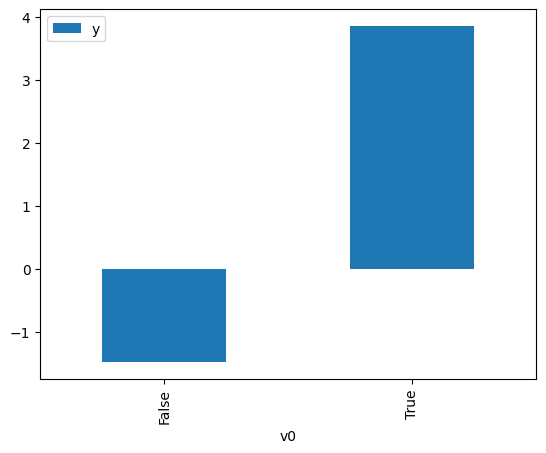

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

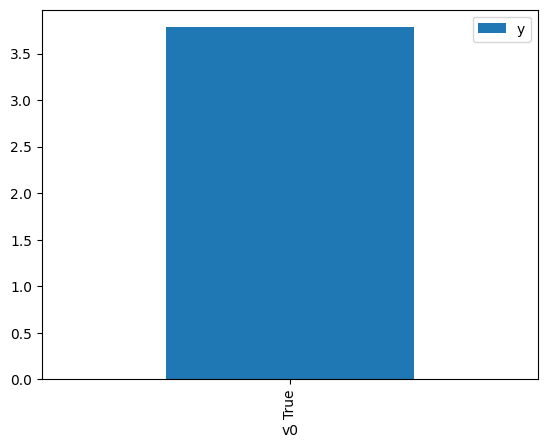

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.099177,False,1.165636,0.540077,1.851587
1,-2.658781,False,-4.367702,0.838147,1.193108
2,0.340326,False,0.342011,0.507727,1.969564
3,-1.642167,False,-1.593175,0.749799,1.333691
4,-1.263552,False,-2.600313,0.709681,1.409083
...,...,...,...,...,...
995,-1.038422,False,-2.281823,0.684107,1.461760
996,-0.927276,False,-3.332519,0.671044,1.490215
997,-1.881835,False,-2.517083,0.773203,1.293321
998,-1.182812,False,-2.044485,0.700650,1.427246


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.046847,True,3.347866,0.314914,3.175467
1,-1.540006,True,1.911344,0.260653,3.836512
2,0.934206,True,7.098800,0.571657,1.749302
3,-1.162980,True,3.568395,0.301593,3.315732
4,-0.792436,True,2.800294,0.345164,2.897170
...,...,...,...,...,...
995,-3.179026,True,-1.544712,0.127371,7.851100
996,-1.078994,True,2.367792,0.311195,3.213421
997,-0.872640,True,3.743529,0.335477,2.980829
998,1.550457,True,8.862792,0.650258,1.537852


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.917
Model:                            OLS   Adj. R-squared (uncentered):              0.917
Method:                 Least Squares   F-statistic:                              5549.
Date:                Tue, 07 Mar 2023   Prob (F-statistic):                        0.00
Time:                        16:37:29   Log-Likelihood:                         -1422.3
No. Observations:                1000   AIC:                                      2849.
Df Residuals:                     998   BIC:                                      2858.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.7355      0.026     67.474      0.000       1.685       1.786
x2             5.0208      0.054     92.790      0.000       4.915       5.127
==============================================================================
Omnibus:                        2.549   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.280   Jarque-Bera (JB):                2.421
Skew:                          -0.115   Prob(JB):                        0.298
Kurtosis:                       3.075   Cond. No.                         2.17
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""